### River contributions in North Water polynya region

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import netCDF4 as nc
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

##### Parameters:

In [12]:
# Domain dimensions:
imin, imax = 1480, 2180
jmin, jmax = 160, 800
isize = imax - imin
jsize = jmax - jmin

# Results folders:
folder = '/data/brogalla/run_storage/ave-tracer-fields/'

# Color map:
N = 256
vals_cont = np.ones((N, 4))
vals_cont[:, 0] = np.linspace(171/N, 1, N)
vals_cont[:, 1] = np.linspace(92/N, 1, N)
vals_cont[:, 2] = np.linspace(41/N, 1, N)
cont_cmap = ListedColormap(vals_cont).reversed()

vals_glac = np.ones((N, 4))
vals_glac[:, 0] = np.linspace(8/N, 1, N)
vals_glac[:, 1] = np.linspace(115/N, 1, N)
vals_glac[:, 2] = np.linspace(180/N, 1, N)
glac_cmap = ListedColormap(vals_glac).reversed()

vals_both = np.ones((N, 4))
vals_both[:, 0] = np.linspace(89/N, 1, N); 
vals_both[:, 1] = np.linspace(89/N, 1, N)
vals_both[:, 2] = np.linspace(89/N, 1, N)
both_cmap = ListedColormap(vals_both).reversed()

land_color = '#a9a7a2'

##### Load files:

In [3]:
# Meshmasks
mask      = nc.Dataset('/ocean/brogalla/GEOTRACES/ariane_runs/ANHA12_Ariane_mesh.nc')
tmask     = np.array(mask.variables['tmask'])
land_mask = np.ma.masked_where((tmask[0,:,:,:] > 0.1) , tmask[0,:,:,:]) 

tmask_full    = np.empty((12,50,isize,jsize))
tmask_full[:] = tmask[0,:,imin:imax,jmin:jmax]

mesh  = nc.Dataset('/data/brogalla/old/meshmasks/ANHA12_mesh1.nc')
lon   = np.array(mesh.variables['nav_lon'])
lat   = np.array(mesh.variables['nav_lat'])

In [4]:
ref   = nc.Dataset('/data/brogalla/run_storage/Mn-set4-202004/ref-2002/ANHA12_EXH006_2002_monthly.nc',  'r')
lons  = np.array(ref.variables['nav_lon'])
lats  = np.array(ref.variables['nav_lat'])
depth = np.array(ref.variables['deptht'])

In [5]:
# Load Mn results
file_ref   = 'ANHA12_EXH006_ref_seasonal_field.nc'
file_glac  = 'ANHA12_EXH006_riv-2a_seasonal_field.nc'
file_cont  = 'ANHA12_EXH006_riv-2b_seasonal_field.nc'

base_monthly = nc.Dataset(folder+file_ref); 
glac_monthly = nc.Dataset(folder+file_glac); 
cont_monthly = nc.Dataset(folder+file_cont);

dmn_base = np.array(base_monthly.variables['dissolmn'])[0,:,0,:,:]
dmn_glac = np.array(glac_monthly.variables['dissolmn'])[0,:,0,:,:]
dmn_cont = np.array(cont_monthly.variables['dissolmn'])[0,:,0,:,:]

##### Functions:

Calculate the proportional contribution of glacial rivers to each grid cell:

$$ prop = \frac{Mn_{glacier}-Mn_{base}}{Mn_{base}} = \frac{Mn_{glacier}}{Mn_{base}} - 1 $$

In [6]:
def calculate_prop(dmn_riv_off, dmn_riv_on):
    # Input arguments:
    # - dmn_riv_on (t,z,y,x) --- concentration of dMn with riverine contribution on
    # - dmn_riv_off(t,z,y,x) --- concentration of dMn with rivers off
    
    diff_rivers = dmn_riv_on - dmn_riv_off
    
    # Contribution of rivers / total concentration (with rivers on):
    # should be an elementwise operation
    prop_river  = np.divide(diff_rivers, dmn_riv_off)
    
    # Output:
    # - prop_river(t,z,y,x)  --- proportional contribution of river to observed [dMn]
    return prop_river

##### Calculations:

In [7]:
glacier_prop      = calculate_prop(dmn_base, dmn_glac)
continental_prop  = calculate_prop(dmn_base, dmn_cont)

In [8]:
# Average over the top meters and summer months
glac_prop = np.nanmean(glacier_prop[:,0:10,:,:], axis=1)
cont_prop = np.nanmean(continental_prop[:,0:10,:,:], axis=1)

# Mask small values:
ma_glac = np.ma.masked_where((glac_prop < 0.005), glac_prop)
ma_cont = np.ma.masked_where((cont_prop < 0.005), cont_prop)
ma_both = ma_cont + ma_glac

In [9]:
refc = np.nanmean(cont_prop[:,:,:], axis=0)
refg = np.nanmean(glac_prop[:,:,:], axis=0)

##### Figures

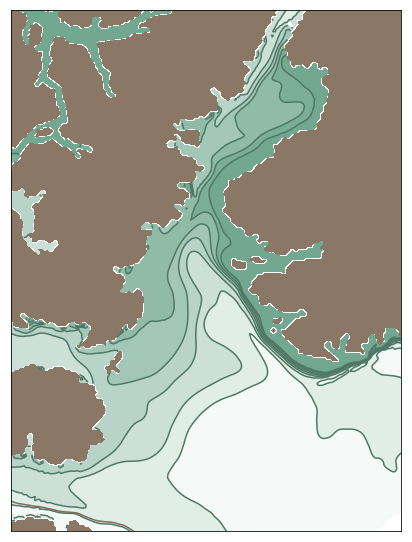

In [50]:
fig, ax2 = plt.subplots(1,1, figsize=(7,10))    
    
proj2 = Basemap(projection='stere',lat_0 = 77.3, lon_0 = -74, resolution='i', width=0.6e6, height=0.8e6, ax=ax2)
x_land, y_land = proj2(lon, lat)
proj2.contourf(x_land[:,:], y_land[:,:], land_mask[10,:,:], \
               cmap=matplotlib.colors.ListedColormap(["#8b7765"]), zorder=2)

x_model, y_model = proj2(lons, lats)

vmin_glac = 0; vmax_glac = 14; step_glac = 2;
vmin_cont = 0; vmax_cont = 14; step_cont = 2;

refc_masked = np.ma.masked_where((refc*100 < 0.25), refc*100)
refg_masked = np.ma.masked_where((refg*100 < 0.25), refg*100)

CS2 = proj2.contourf(x_model, y_model, refc_masked, \
                     levels=np.arange(vmin_cont, vmax_cont+step_cont, step_cont), \
                     vmin=vmin_cont, vmax=vmax_cont, cmap=cont_cmap, extend='both')
CS1 = proj2.contourf(x_model, y_model, refg_masked, \
                     levels=np.arange(vmin_glac, vmax_glac+step_glac, step_glac), \
                     vmin=vmin_glac, vmax=vmax_glac, cmap=glac_cmap, extend='both')


vmin_cglac = 0; contour_glac = 2; cvmax_glac = 14;
vmin_ccont = 0; contour_cont = 2; cvmax_cont = 14;
glac = proj2.contour(x_model, y_model, refg_masked, \
                     levels=np.arange(vmin_cglac, cvmax_glac+contour_glac, contour_glac), \
                     vmin=vmin_cglac, vmax=vmax_glac, colors='#507866')
cont = proj2.contour(x_model, y_model, refc_masked, \
                     levels=np.arange(vmin_ccont, cvmax_cont+contour_cont, contour_cont), \
                     vmin=vmin_ccont, vmax=vmax_cont, colors='#816a5a')

proj2.plot(x_land[imax:-1,:] , y_land[imax:-1,:] , '-', color='#d8d9da', linewidth=10, zorder=1);
proj2.plot(x_land[:,jmax:-1] , y_land[:,jmax:-1] , '-', color='#d8d9da', linewidth=10, zorder=1);
proj2.plot(x_land[:,0:jmin]  , y_land[:,0:jmin]  , '-', color='#d8d9da', linewidth=10, zorder=1);
proj2.plot(x_land[0:imin,:]  , y_land[0:imin,:]  , '-', color='#d8d9da', linewidth=10, zorder=1);
    
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/paper2/-monthly-CAA.png', bbox_inches='tight', dpi=300)

In [10]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', \
         'September', 'October', 'November', 'December']

In [42]:
month_show = [3, 4, 5, 6, 7]

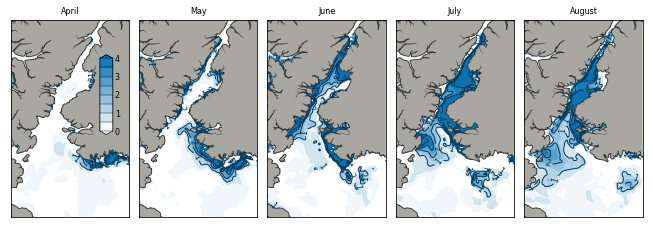

In [48]:
fig, ax1 = plt.subplots(1,5, figsize=(16,6))

i=0
for panel in ax1:
    month = month_show[i]
    
    proj2 = Basemap(projection='stere',lat_0 = 77.9, lon_0 = -71, resolution='i', \
                    width=0.6e6, height=1.0e6, ax=panel)
    proj2.drawcoastlines(color='#373736', linewidth=1.8,zorder=2)
    proj2.fillcontinents(color=land_color, lake_color=land_color, zorder=2);

    x_model, y_model = proj2(lons, lats)
    difference_g = np.ma.masked_where((ma_glac[month,:,:]-ma_glac[month-1,:,:]) < 0, \
                                      (ma_glac[month,:,:]-ma_glac[month-1,:,:])*100)

    # Coloured contours:
    vmin_glac = 0; vmax_glac = 4; step_glac = .5;
    CS1 = proj2.contourf(x_model, y_model, difference_g, \
                         levels=np.arange(vmin_glac, vmax_glac+step_glac, step_glac), \
                         vmin=vmin_glac, vmax=vmax_glac, cmap=glac_cmap, extend='both')
    # Contour lines:
    vmin_cglac=0; cvmax_glac = 4; contour_glac = 1; 
    glac = proj2.contour(x_model, y_model, difference_g, \
                         levels=np.arange(vmin_cglac, cvmax_glac+contour_glac, contour_glac), \
                         vmin=vmin_cglac, vmax=vmax_glac, colors='#04395a', linewidths=1.0)

    panel.clabel(glac, [1, 2, 4], inline=1, fontsize=8, fmt='%1.f')
    panel.set_title(months[month], fontsize=8)
    
    i+=1


plt.tight_layout()

# Colorbars:
cbaxes1 = fig.add_axes([0.15, 0.45, 0.02, 0.25]) 
CBar1   = plt.colorbar(CS1, ax=ax1[0], cax=cbaxes1, ticks=np.arange(0,10,1), drawedges=True)  
CBar1.ax.tick_params(axis='y', length=0, labelsize=8, pad=2)

figure  = plt.gcf()
figure.set_size_inches(4.5*2, 3.7*1.2)
figure.savefig('/ocean/brogalla/GEOTRACES/figures/paper2/D2-NOW-climatology.png', bbox_inches='tight', dpi=300)
figure.savefig('/ocean/brogalla/GEOTRACES/figures/paper2/D2-NOW-climatology.svg', bbox_inches='tight', dpi=300, format='svg')